In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Project
## Tesla Stock Price Predictive ML Improved Model Analysis 

In [11]:
df=pd.read_csv(r"c:\Users\user\Desktop\Kaggle Datasets\Tesla_stock_data.csv")

# Data Info

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3765 entries, 0 to 3764
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3765 non-null   object 
 1   Close   3765 non-null   float64
 2   High    3765 non-null   float64
 3   Low     3765 non-null   float64
 4   Open    3765 non-null   float64
 5   Volume  3765 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 176.6+ KB


In [13]:
df.shape

(3765, 6)

In [14]:
df.describe()

,Close,High,Low,Open,Volume
count,3765.000000,3765.000000,3765.000000,3765.000000,3.765000e+03
mean,88.567852,90.581117,86.465378,88.593070,9.707503e+07
std,113.754319,116.450259,110.987632,113.848771,7.689793e+07
min,1.053333,1.108667,0.998667,1.076000,1.777500e+06
25%,12.506000,12.764667,12.183333,12.446667,5.014650e+07
50%,18.807333,19.118668,18.466667,18.799999,8.319150e+07
75%,191.300003,196.360001,186.339996,191.456665,1.225740e+08
max,479.859985,488.540009,457.510010,475.899994,9.140820e+08


# Data Handling & Cleaning

In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)


# Feature Engineering 

In [16]:
# Feature engineering
df['MA20'] = df['Close'].rolling(20).mean()
df['MA50'] = df['Close'].rolling(50).mean()
df['Daily Return'] = df['Close'].pct_change()
df['Open-Close'] = df['Open'] - df['Close']
df['High-Low'] = df['High'] - df['Low']
df['Volatility'] = df['High-Low'] / df['Open']

# Lag features to preserve time order
for lag in [1, 2, 3]:
    df[f'Close_lag_{lag}'] = df['Close'].shift(lag)

df.dropna(inplace=True)

features = ['Open', 'High', 'Low', 'Volume', 'MA20', 'MA50', 
            'Open-Close', 'High-Low', 'Volatility', 
            'Close_lag_1', 'Close_lag_2', 'Close_lag_3']

X = df[features]
y = df['Close']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Time Series Split

In [17]:
# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

rf = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(rf, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_scaled, y)

best_rf = grid.best_estimator_

Random Forest (improved) R2: 0.9774227803432626
Random Forest (improved) RMSE: 9.951339974808802


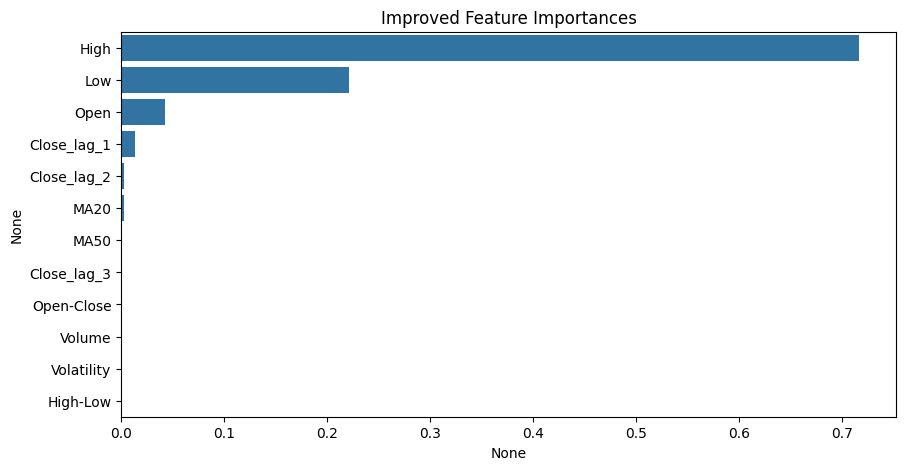

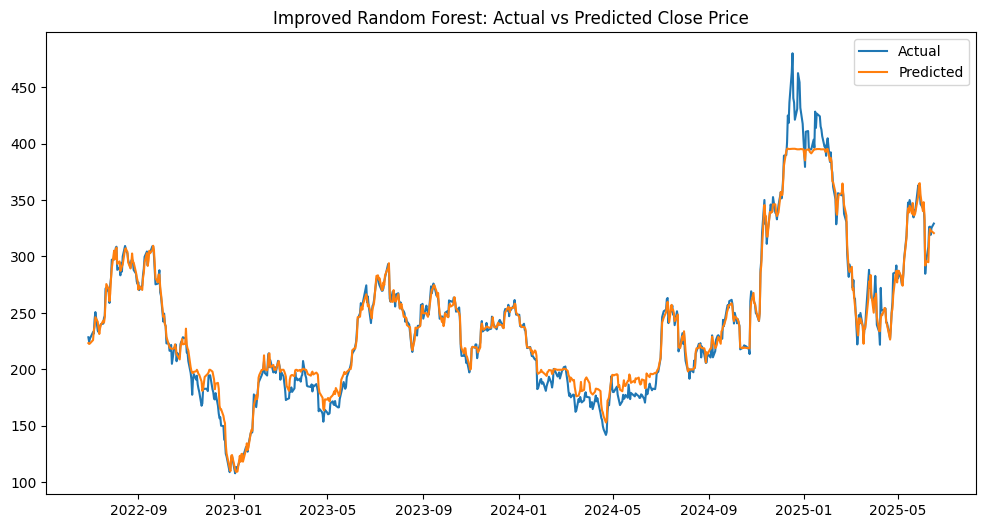

In [18]:
# final prediction on last split
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

print("Random Forest (improved) R2:", r2_score(y_test, y_pred))
print("Random Forest (improved) RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

importances = pd.Series(best_rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(x=importances, y=importances.index)
plt.title('Improved Feature Importances')
plt.show()

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.title('Improved Random Forest: Actual vs Predicted Close Price')
plt.legend()
plt.show()

# Correlation Heatmap

<Axes: >

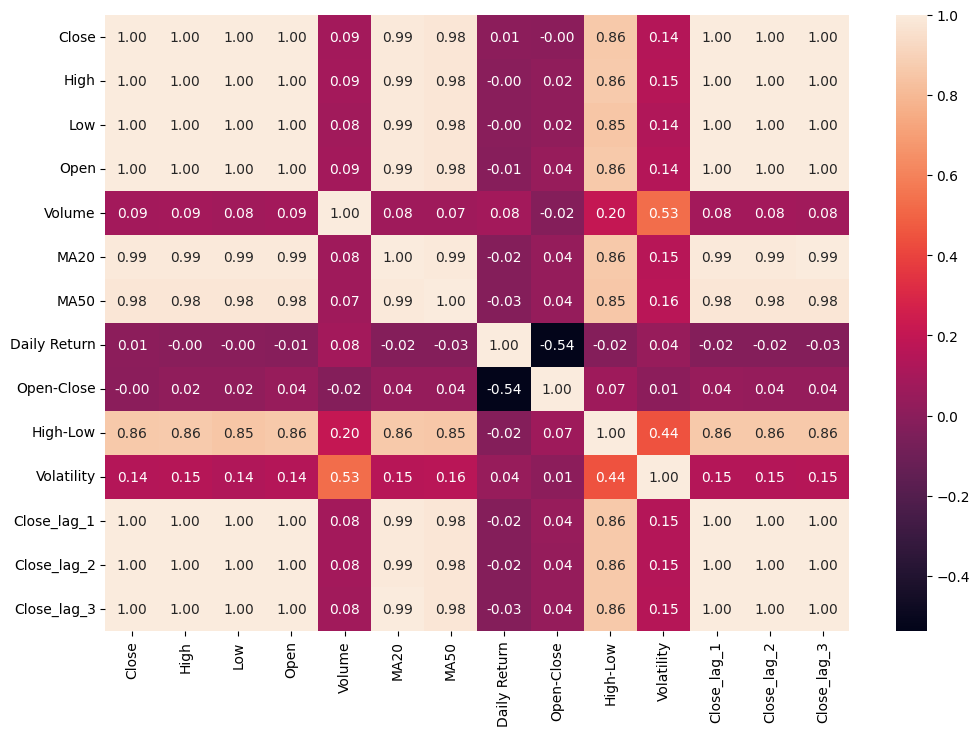

In [19]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(),annot=True,fmt=".2f")